
# Automatic Brain Tumor Detection and Segmentation 

## Using U-Net 

Mohammad Reza Tabrizi

# Importar dados
### A seguinte função auxilia na importação dos dados recolhidos dos vários repositórios, associando a respetiva label aos mesmos. Os dados são convertidos em arrays:

In [ ]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

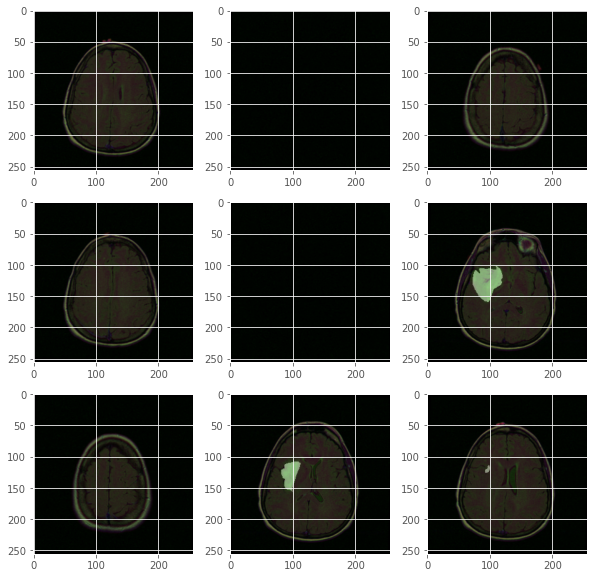

In [ ]:
rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_path=train_files[i]
    msk_path=mask_files[i]
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)
    plt.imshow(img)
    plt.imshow(msk,alpha=0.4)
plt.show()

In [ ]:
X_train = np.zeros((len(df), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(df), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

In [ ]:

for i in tqdm(range (len(df))):
    img_path=train_files[i]
    img=cv2.imread(img_path)[:,:,:IMG_CHANNELS] 
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[i] = img
    msk_path=mask_files[i]
    mask_ =cv2.imread(msk_path)
    mask_ = rgb2gray(mask_)
    mask_.shape
    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                              preserve_range=True), axis=-1)
    Y_train[i] = mask_

100%|██████████| 3929/3929 [00:44<00:00, 89.19it/s]


In [ ]:
smooth=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)
print(X_train1.shape)
print(X_test1.shape)

(3536, 128, 128, 3)
(393, 128, 128, 3)


# Sanety check, View few Images

<function matplotlib.pyplot.show>

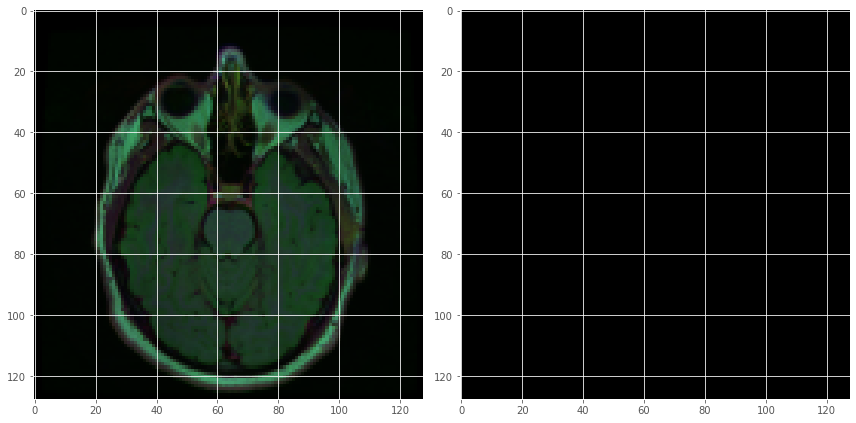

In [ ]:
image_number = random.randint(0,len(X_train1))
plt.figure(figsize=(12,6))
plt.subplot(121)
imshow(X_train1[image_number])
plt.subplot(122)
imshow(np.squeeze(y_train1[image_number]))
plt.show

### As funções seguintes apresentam  configurações de redes neuronais UNet, a testar nas secções seguintes:

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 128, 128, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_76 (Conv2D)              (None, 128, 128, 16) 448         lambda_4[0][0]                   
__________________________________________________________________________________________________
dropout_36 (Dropout)            (None, 128, 128, 16) 0           conv2d_76[0][0]                  
____________________________________________________________________________________________

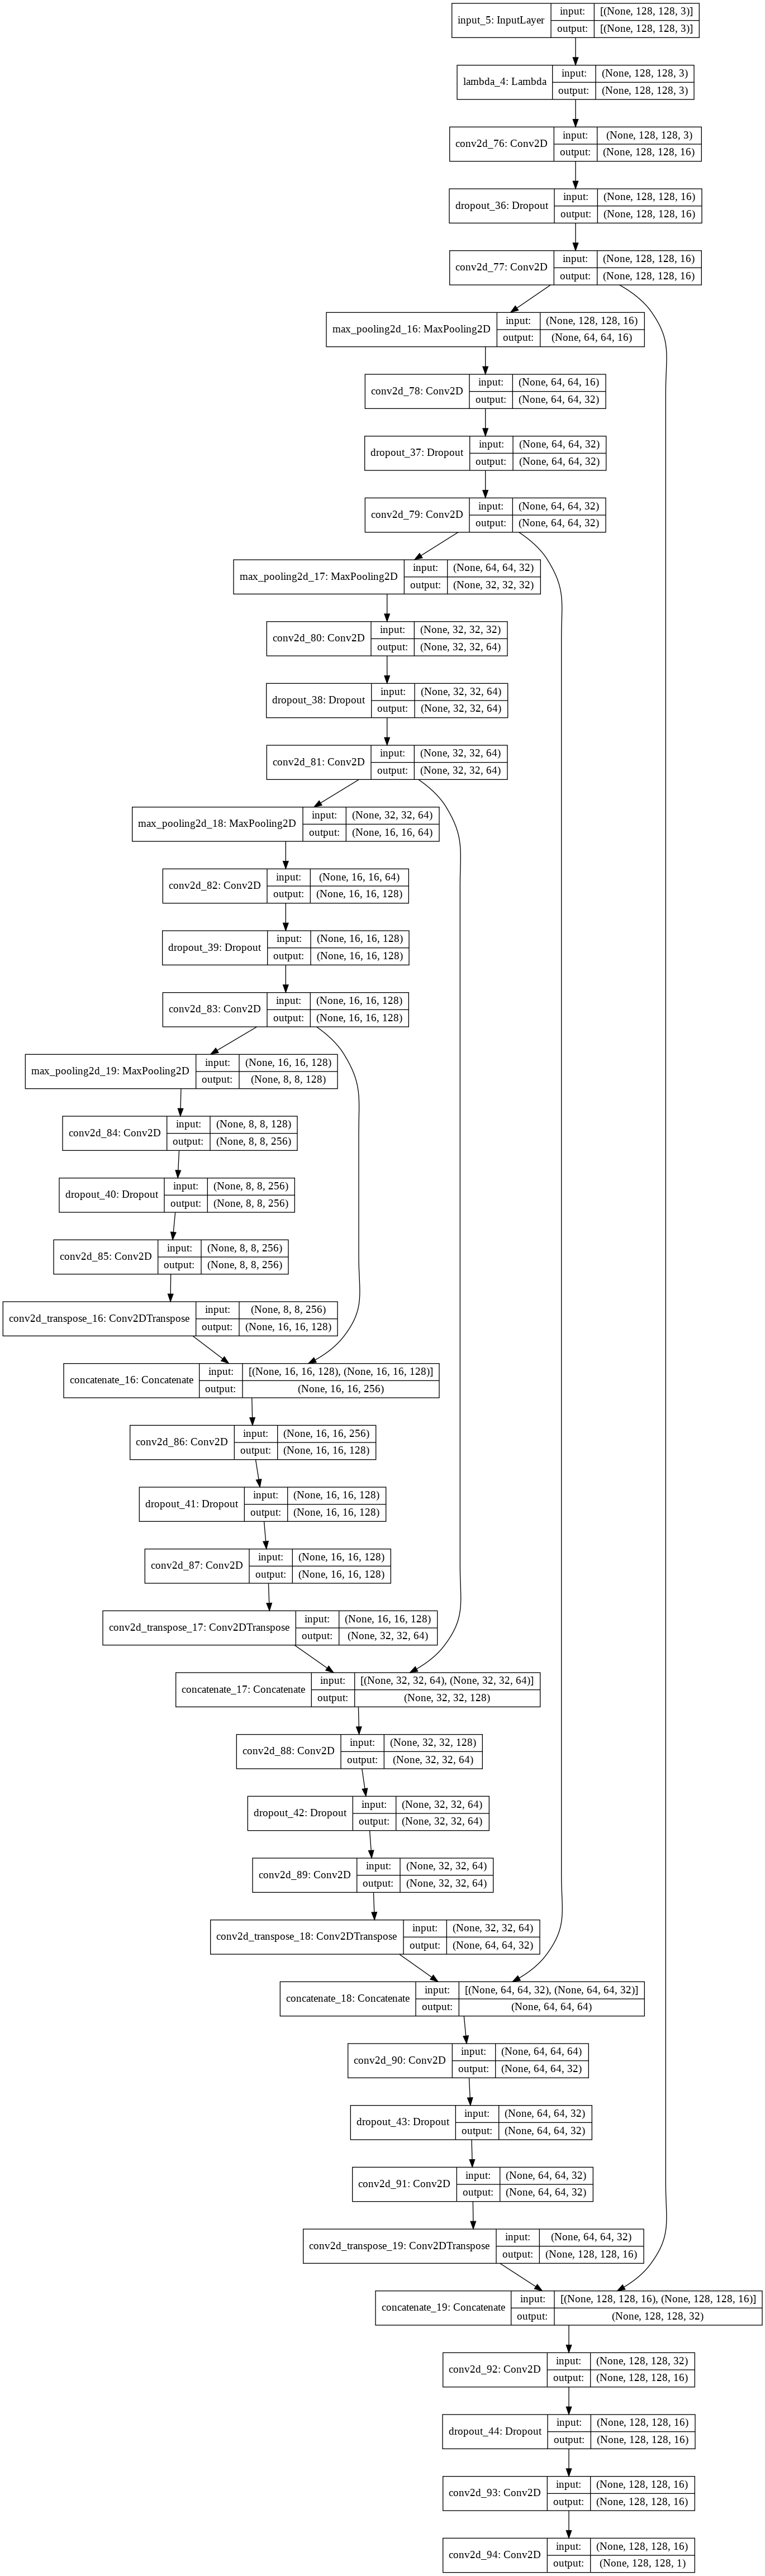

In [ ]:
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=["binary_accuracy", iou])
model.summary()
tf.keras.utils.plot_model(model, "model5.png", show_shapes = True)



In [ ]:
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('simple_unet_model.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=100, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]
history = model.fit(X_train1, y_train1,
                    batch_size= 16,
                    verbose= 1,
                    epochs= 100,
                    validation_data= (X_test1,y_test1),
                    shuffle=False,
                    callbacks=callbacks)


#model.save('simple_unet_model.hdf5')

Epoch 1/100
221/221 [==============================] - 11s 43ms/step - loss: 0.1376 - binary_accuracy: 0.9859 - iou: 0.0455 - val_loss: 0.0368 - val_binary_accuracy: 0.9875 - val_iou: 0.1348
Epoch 2/100
221/221 [==============================] - 9s 40ms/step - loss: 0.0383 - binary_accuracy: 0.9861 - iou: 0.1570 - val_loss: 0.0424 - val_binary_accuracy: 0.9875 - val_iou: 0.1173
Epoch 3/100
221/221 [==============================] - 9s 41ms/step - loss: 0.0336 - binary_accuracy: 0.9872 - iou: 0.1998 - val_loss: 0.0276 - val_binary_accuracy: 0.9898 - val_iou: 0.2849
Epoch 4/100
221/221 [==============================] - 9s 41ms/step - loss: 0.0286 - binary_accuracy: 0.9913 - iou: 0.3170 - val_loss: 0.0312 - val_binary_accuracy: 0.9894 - val_iou: 0.2962
Epoch 5/100
221/221 [==============================] - 9s 41ms/step - loss: 0.0259 - binary_accuracy: 0.9919 - iou: 0.3573 - val_loss: 0.0211 - val_binary_accuracy: 0.9930 - val_iou: 0.3852
Epoch 6/100
221/221 [============================

# Visualization result UNet Models

In [ ]:
y_pred = model.predict(X_test1,verbose=0)
y_pred_trasholded = y_pred > 0.5

intersection = np.logical_and(y_test1, y_pred_trasholded)
union = np.logical_or(y_test1,y_pred_trasholded)
iou_score = np.sum(intersection)/ np.sum(union)
print ("IoU score is: ",iou_score)

IoU score is:  0.8330357038645144


/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


<function matplotlib.pyplot.show>

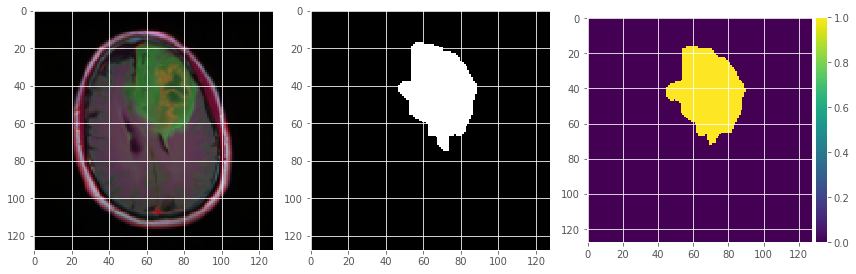

In [ ]:

#preds_test = model.predict(X_test1, verbose=0)

preds_test_t = (y_pred > 0.5).astype(np.uint8)


# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_test_t))
plt.figure(figsize=(12,6))
plt.subplot(131)
imshow(X_test1[ix])
plt.subplot(132)
imshow(np.squeeze(y_test1[ix]))
plt.subplot(133)
imshow(np.squeeze(preds_test_t[ix]))
plt.show



In [ ]:
history.history.keys()

dict_keys(['loss', 'binary_accuracy', 'iou', 'val_loss', 'val_binary_accuracy', 'val_iou'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


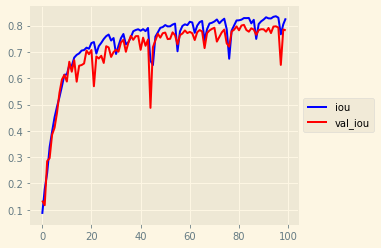

In [ ]:
with plt.style.context('Solarize_Light2'):
  plt.plot((history.history['iou']),label='iou', linestyle='-', color='b')
  plt.plot((history.history['val_iou']),label='val_iou', linestyle='-', color='r')
  ax = plt.subplot(111)
  box = ax.get_position()
  ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
  ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.legend(loc='best')

plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


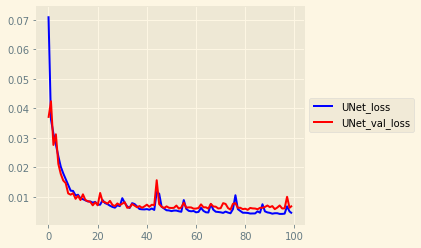

In [ ]:
with plt.style.context('Solarize_Light2'):
  plt.plot((history.history['loss']),label='UNet_loss', linestyle='-', color='b')
  plt.plot((history.history['val_loss']),label='UNet_val_loss', linestyle='-', color='r')
  ax = plt.subplot(111)
  box = ax.get_position()
  ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
  ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.legend(loc='best')

plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


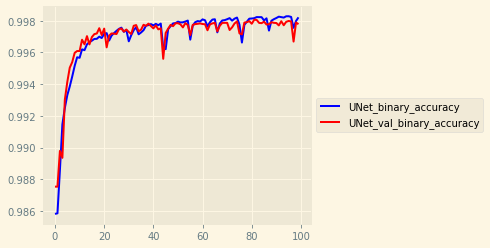

In [ ]:
with plt.style.context('Solarize_Light2'):
  plt.plot((history.history['binary_accuracy']),label='UNet_binary_accuracy', linestyle='-', color='b')
  plt.plot((history.history['val_binary_accuracy']),label='UNet_val_binary_accuracy', linestyle='-', color='r')
  ax = plt.subplot(111)
  box = ax.get_position()
  ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
  ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.legend(loc='best')

plt.show()